In [1]:
# NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION
# (ref) https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load data files
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:"SOS", 1:"EOS"}
        self.n_words = 2  #count SOS and EOS
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
# turn unicode to ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# trim strings and use lowercase
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]", r" ", s)
    return s

# read language data file
def readLangs(lang1, lang2, reverse=False): 
    print("Reading lines...")
    lines = open('data/{}-{}.txt'.format(lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    if reverse: 
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

# use relatively short sentences 
MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ", "he is", "he s ", "she is", "she s", 
    "you are", "you re ", "we are", "we re ", "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# prepares data
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read {} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData("eng", "fra", True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10676 sentence pairs
Counting words...
Counted words:
fra 4464
eng 2914
['ils se sourient .', 'they re smiling at each other .']


In [2]:
### Seq2Seq Model (or Encoder Decoder Network)

# encoder reads an input sequence and outputs a single vector
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
# decoder produce an output sequence 
#   - the initial input token is SOS
#   - the first hidden state is the context vector
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1,1,-1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
# attention decoder
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)),dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),   #bmm: batch matrix multiplication
                                 encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]),dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)       

In [3]:
### Training 

# prepare training data
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [4]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, 
          criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # teacher forcing: feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        # w/o teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
                
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [5]:
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
plt.switch_backend('agg')

def asMinutes(s):
    m = math.floor(s/60)
    s -= m*60
    return '{:3.0f}m {:3.0f}s'.format(m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '{} (-{})'.format(asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [6]:
# iteration 
def trainIters(encoder, decoder, n_iters, 
               print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('{} ({} {:.1f}%) {:.4f}'.format(
                timeSince(start, iter/n_iters),
                iter, iter/n_iters*100, print_loss_avg))
        
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    showPlot(plot_losses)

In [7]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0,0]
        
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
        
        return decoded_words, decoder_attentions[:di+1]

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('> {}'.format(pair[0]))
        print('= {}'.format(pair[1]))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('< {}'.format(output_sentence))
        print('')

  3m  33s (-129m  23s) (2000 2.7%) 3.2359
  6m  46s (-120m   0s) (4000 5.3%) 2.6980
  9m  56s (-114m  19s) (6000 8.0%) 2.4989
 13m  16s (-111m   6s) (8000 10.7%) 2.3488
 16m  49s (-109m  18s) (10000 13.3%) 2.2219
 19m  58s (-104m  52s) (12000 16.0%) 2.1031
 23m   9s (-100m  51s) (14000 18.7%) 1.9774
 26m  20s (- 97m   6s) (16000 21.3%) 1.8273
 29m  45s (- 94m  12s) (18000 24.0%) 1.7862
 33m   1s (- 90m  48s) (20000 26.7%) 1.6920
 36m  16s (- 87m  21s) (22000 29.3%) 1.6086
 39m  26s (- 83m  47s) (24000 32.0%) 1.5496
 42m  40s (- 80m  25s) (26000 34.7%) 1.4889
 45m  51s (- 76m  59s) (28000 37.3%) 1.4006
 49m   4s (- 73m  36s) (30000 40.0%) 1.3464
 52m  23s (- 70m  23s) (32000 42.7%) 1.3034
 55m  35s (- 67m   2s) (34000 45.3%) 1.2603
 58m  47s (- 63m  41s) (36000 48.0%) 1.1935
 62m   9s (- 60m  30s) (38000 50.7%) 1.1175
 65m  34s (- 57m  23s) (40000 53.3%) 1.1281
 68m  53s (- 54m   7s) (42000 56.0%) 1.0305
 71m  55s (- 50m  40s) (44000 58.7%) 1.0110
 75m   5s (- 47m  20s) (46000 61.3%) 0.

<Figure size 432x288 with 0 Axes>

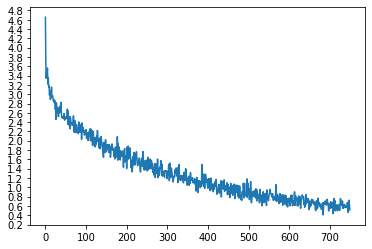

In [8]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=2000)

In [9]:
evaluateRandomly(encoder1, attn_decoder1)

> je ne suis pas fou .
= i m not mad .
< i m not mad . <EOS>

> je ne suis pas convaincue .
= i m unconvinced .
< i m not convinced . <EOS>

> je suis pret pour le pire .
= i am prepared for the worst .
< i m ready for the worst . <EOS>

> ils sont de retour .
= they re back .
< they are back . <EOS>

> vous etes vieilles .
= you re old .
< you re old . <EOS>

> il est employe de banque .
= he is employed in a bank .
< he is a bank clerk . <EOS>

> il a des chances de gagner le jeu .
= he is likely to win the game .
< he is likely to win the game . <EOS>

> il est fort comme un cheval .
= he s as strong as a horse .
< he is as strong as a . . <EOS>

> elles sont toujours ensemble .
= they re still together .
< they re still together . <EOS>

> je suis agriculteur .
= i m a farmer .
< i m a . <EOS>



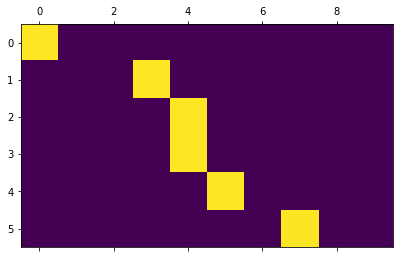

In [10]:
# visualization: looking where the network is focused most
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


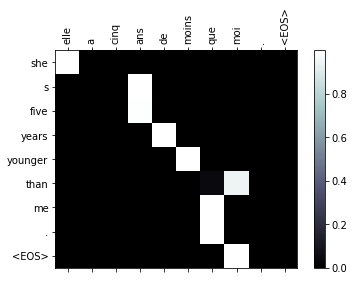

input = elle est trop petit .
output = she s too short . <EOS>


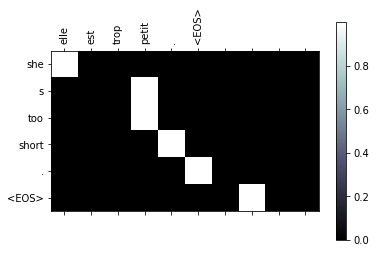

input = je ne crains pas de mourir .
output = i m afraid afraid of dying . <EOS>


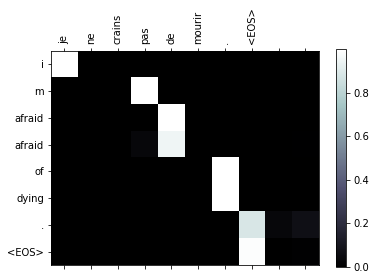

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


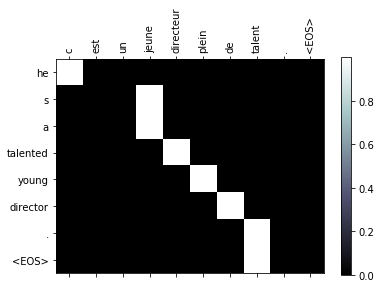

In [11]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)
    
    ax.set_xticklabels(['']+input_sentence.split(' ')+
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels(['']+output_words)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention("elle a cinq ans de moins que moi .")
evaluateAndShowAttention("elle est trop petit .")
evaluateAndShowAttention("je ne crains pas de mourir .")
evaluateAndShowAttention("c est un jeune directeur plein de talent .")